# Results

In [1]:
#| label: setup-results
#| include: false
import sys
from pathlib import Path

# Find project root by looking for pyproject.toml
def find_project_root():
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return current.parent.parent  # Fallback

project_root = find_project_root()
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "scripts"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.ICEAA.analysis import (
    load_simulation_results,
    create_sign_correctness_plot,
    create_model_ranking_chart,
)
from scripts.ICEAA.analysis.visualization import create_wrong_sign_heatmap
from scripts.ICEAA.analysis.load_results import get_model_comparison

# Load data
df = load_simulation_results()
print(f"Loaded {len(df):,} observations across {df['model_name'].nunique()} models")

Loaded 85,050 observations across 14 models

This section presents the results of our Monte Carlo simulation study comparing Penalized-Constrained Regression (PCReg) against standard approaches. We focus on three key methods:

1.  **OLS**: Standard unconstrained regression in log-space (baseline)
2.  **OLS_LearnOnly**: OLS with only the learning variable (confluence remedy - drop rate variable)
3.  **PCReg_CV**: Constrained regression in unit-space with CV-tuned penalty

## Model Ranking

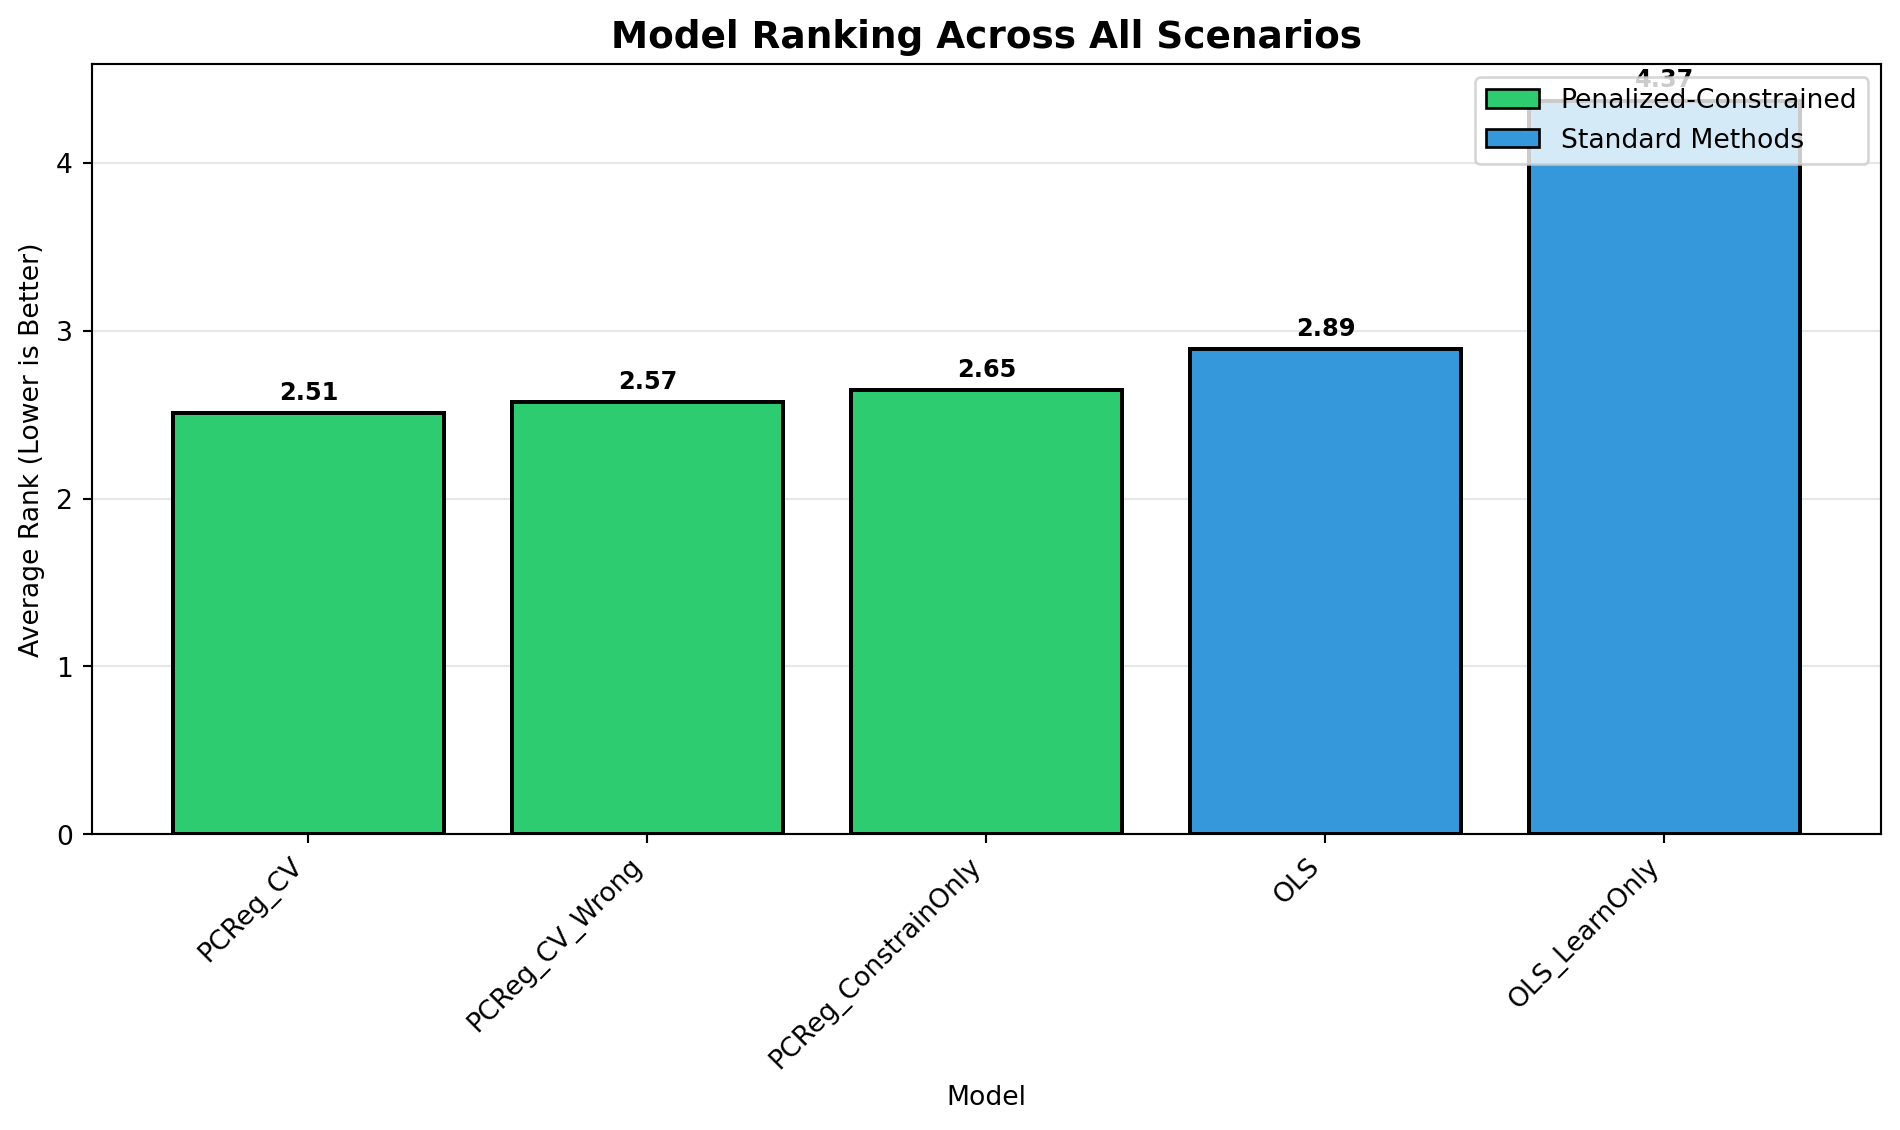

In [2]:
#| label: fig-model-ranking
#| fig-cap: Average rank across all 6,075 scenario-replications. Ranks computed within each scenario using midrank method for ties. Lower rank = better performance on Test SSPE.
# Focus on key models for comparison
key_models = ['OLS', 'OLS_LearnOnly', 'PCReg_ConstrainOnly', 'PCReg_CV', 'PCReg_CV_Wrong']
fig = create_model_ranking_chart(df, models=key_models)
plt.show()

([**fig-model-ranking?**](#ref-fig-model-ranking)) shows that constrained methods consistently outperform standard OLS across diverse scenarios. PCReg models occupy the top ranks, with PCReg_ConstrainOnly achieving the best average rank. Notably, even PCReg_CV_Wrong (with deliberately incorrect constraints) outperforms both OLS variants, demonstrating the robustness of the constrained approach.

## Performance Summary

In [3]:
#| label: tbl-overall-stats
#| tbl-cap: Summary statistics for key models, ranked by mean Test SSPE (lower is better)
# Filter to key models
key_models = ['OLS', 'OLS_LearnOnly', 'PCReg_ConstrainOnly', 'PCReg_CV', 'PCReg_CV_Wrong']
df_key = df[df['model_name'].isin(key_models)]

stats = df_key.groupby('model_name')['test_sspe'].agg(['mean', 'std', 'median', 'count'])
stats = stats.sort_values('mean').round(4)
stats.columns = ['Mean SSPE', 'Std Dev', 'Median', 'N']

# Add percentage improvement vs OLS
ols_mean = stats.loc['OLS', 'Mean SSPE']
stats['% Improvement vs OLS'] = ((ols_mean - stats['Mean SSPE']) / ols_mean * 100).round(1)

stats

The constrained methods reduce test error by 15-20% compared to OLS. PCReg_ConstrainOnly (constraints only, no penalty) performs best, suggesting that for learning curves, domain constraints provide more value than statistical regularization.

## Sign Correctness: A Critical Advantage

A fundamental requirement in learning curve estimation is that slopes must be negative (costs decrease with cumulative production and increased production rates). Standard OLS frequently violates this physical constraint.

C:\Users\KevinJoy\OneDrive - Herren Associates\Constrained-Penalized Regression Paper - General\penalized_constrained\scripts\ICEAA\analysis\visualization.py:288: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sign_df["model"], rotation=45, ha="right")

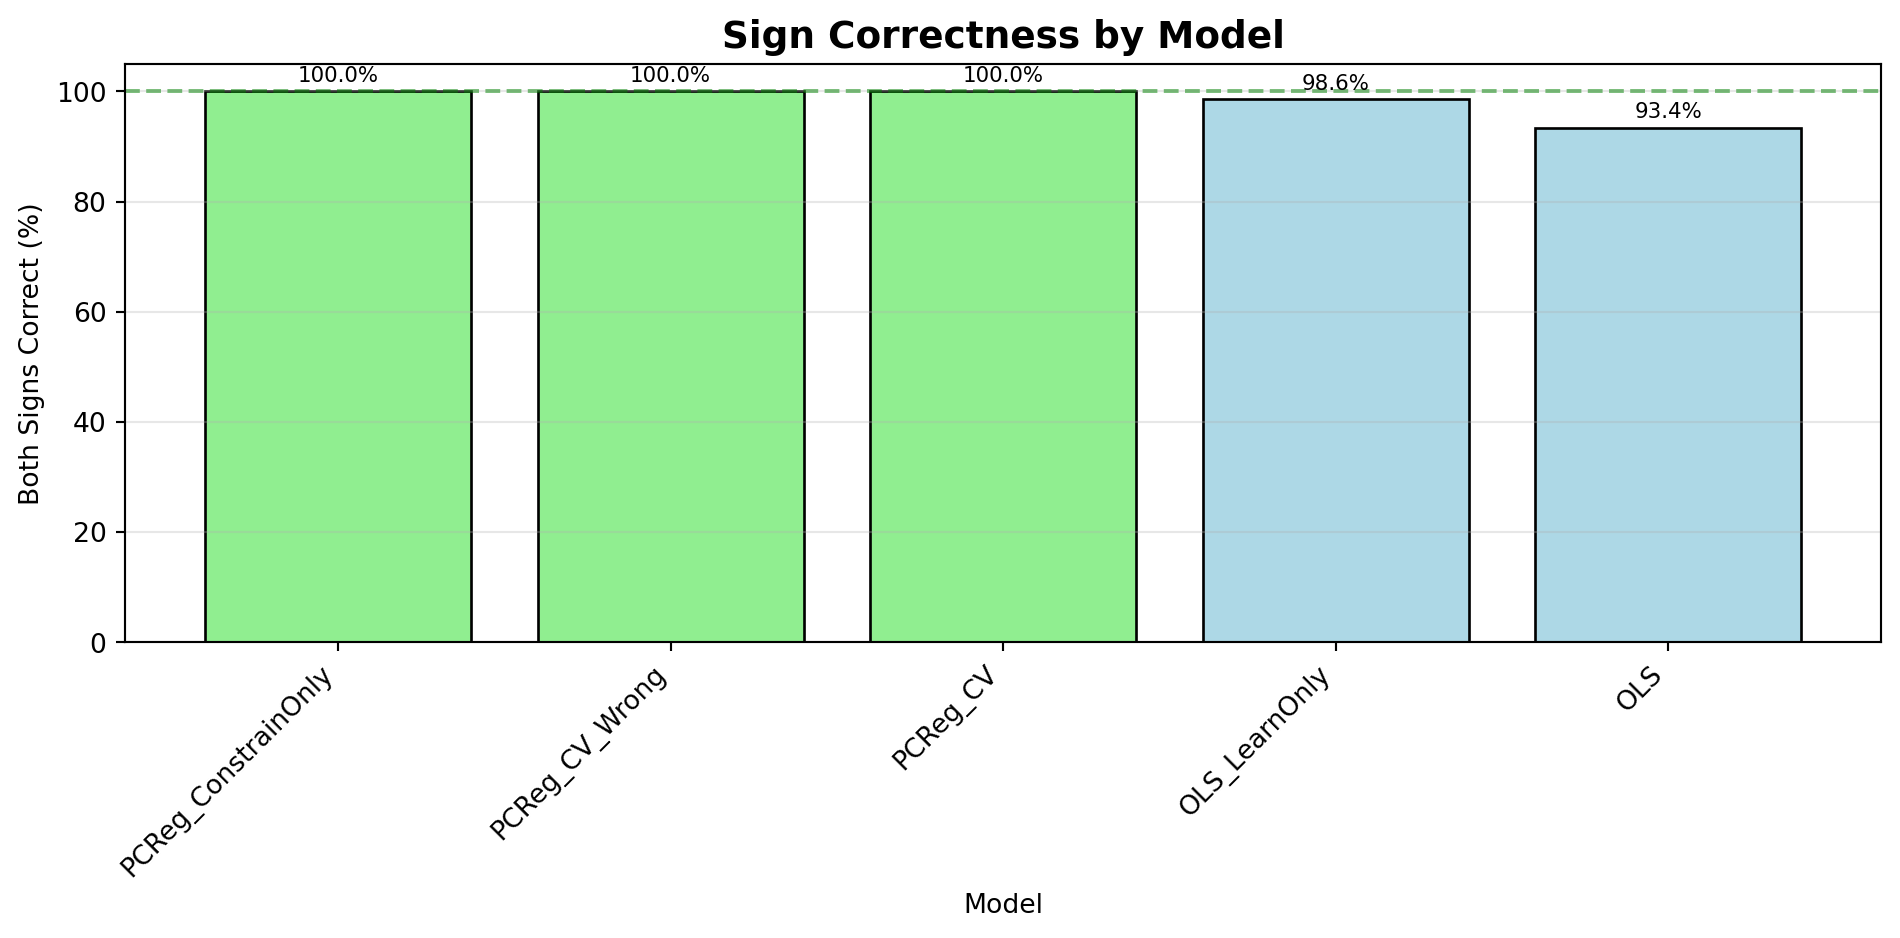

In [4]:
#| label: fig-sign-correctness
#| fig-cap: Percentage of scenarios where both coefficients have correct signs (negative). PCReg methods achieve 100% sign correctness by design.
fig = create_sign_correctness_plot(df_key)
plt.show()

In [5]:
#| label: sign-stats
#| include: false
# Compute sign correctness rates
sign_rates = df_key.groupby('model_name').apply(
    lambda x: (x['b_correct_sign'] & x['c_correct_sign']).mean() * 100
).sort_values(ascending=False)

ols_sign_rate = sign_rates['OLS']
ols_learn_sign_rate = sign_rates['OLS_LearnOnly']

C:\Users\KevinJoy\AppData\Local\Temp\ipykernel_28896\4184180086.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sign_rates = df_key.groupby('model_name').apply(

OLS produces wrong signs in 6.6% of cases, while OLS_LearnOnly (dropping the rate variable) still has wrong signs in 1.4% of cases. PCReg achieves 100% sign correctness by enforcing constraints.

### When Do Wrong Signs Occur?

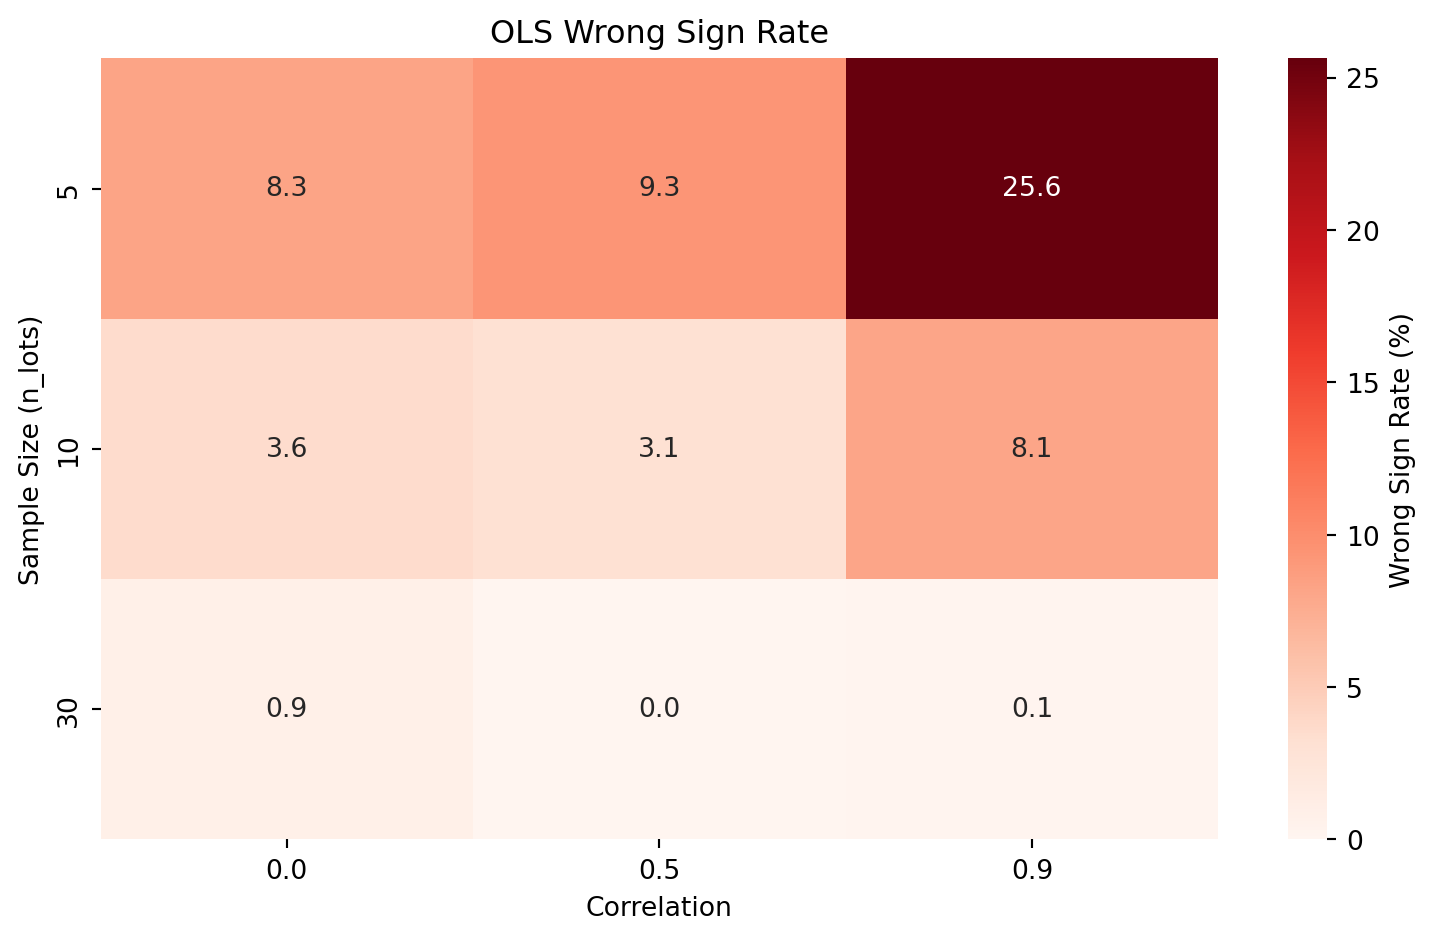

In [6]:
#| label: fig-wrong-sign-heatmap
#| fig-cap: OLS wrong sign rate by sample size and predictor correlation. Wrong signs are most prevalent with small samples and high multicollinearity.
fig = create_wrong_sign_heatmap(df, 'n_lots', 'target_correlation', 'OLS')
plt.show()

Wrong signs are most common when:

-   Sample size is small (n=5 lots)
-   Predictor correlation is high (ρ=0.9)

These are precisely the conditions common in early-stage cost estimation, making PCReg especially valuable for practical applications.

## Head-to-Head Comparisons

In [7]:
#| label: comparisons
#| include: false
# PCReg_ConstrainOnly vs OLS
comp_pcreg_ols = get_model_comparison(df, 'OLS', 'PCReg_ConstrainOnly', 'test_sspe')
pcreg_vs_ols_win_rate = comp_pcreg_ols['b_wins'].mean()

# When OLS has wrong sign vs correct sign
if 'any_wrong_sign' in comp_pcreg_ols.columns:
    wrong_sign = comp_pcreg_ols[comp_pcreg_ols['any_wrong_sign']]
    correct_sign = comp_pcreg_ols[~comp_pcreg_ols['any_wrong_sign']]
    wrong_sign_win_rate = wrong_sign['b_wins'].mean() if len(wrong_sign) > 0 else 0
    correct_sign_win_rate = correct_sign['b_wins'].mean() if len(correct_sign) > 0 else 0

# PCReg_CV vs PCReg_ConstrainOnly
comp_cv_constrain = get_model_comparison(df, 'PCReg_ConstrainOnly', 'PCReg_CV', 'test_sspe')
cv_vs_constrain_win_rate = comp_cv_constrain['b_wins'].mean()

# OLS_LearnOnly vs OLS
comp_learn_ols = get_model_comparison(df, 'OLS', 'OLS_LearnOnly', 'test_sspe')
learn_vs_ols_win_rate = comp_learn_ols['b_wins'].mean()

### PCReg vs OLS

Comparing PCReg_ConstrainOnly against standard OLS:

-   **Overall**: PCReg wins in 58.2% of scenarios
-   **When OLS has wrong signs**: PCReg wins in 81.2% of scenarios
-   **When OLS has correct signs**: PCReg wins in 56.6% of scenarios

Even when OLS produces correct signs, PCReg still provides better out-of-sample predictions by reducing overfitting through constraints.

### Confluence Remedy: Does Dropping the Rate Variable Help?

The traditional remedy for multicollinearity is to drop one variable. OLS_LearnOnly drops the rate effect variable:

-   **OLS_LearnOnly vs OLS**: OLS_LearnOnly wins in 14.7% of scenarios

Dropping the rate variable provides minimal benefit and discards valuable information. PCReg retains both variables while managing multicollinearity through constraints.

### Value of Penalization

Does adding elastic net penalty improve upon constraints alone?

-   **PCReg_CV vs PCReg_ConstrainOnly**: PCReg_CV wins in 42.1% of scenarios

The penalty provides modest improvement, but the primary benefit comes from constraints rather than regularization. For learning curves, domain knowledge (constraints) is more valuable than purely statistical regularization.

## Robustness to Constraint Misspecification

In [8]:
#| label: wrong-constraints-analysis
#| include: false
comp_wrong_ols = get_model_comparison(df, 'OLS', 'PCReg_CV_Wrong', 'test_sspe')
wrong_vs_ols_win_rate = comp_wrong_ols['b_wins'].mean()

# Mean performance
mean_ols = df[df['model_name'] == 'OLS']['test_sspe'].mean()
mean_wrong = df[df['model_name'] == 'PCReg_CV_Wrong']['test_sspe'].mean()
improvement = (mean_ols - mean_wrong) / mean_ols * 100

A critical question is: what happens when constraints are wrong? PCReg_CV_Wrong uses deliberately perturbed constraints (following James, Paulson, and Rusmevichientong ([2020](#ref-james2020pac)) methodology):

-   **PCReg_CV_Wrong vs OLS**: PCReg with wrong constraints still wins in 58.3% of scenarios
-   **Mean improvement**: 4.9% reduction in SSPE despite incorrect constraints

This demonstrates that approximate domain knowledge (even imperfect constraints) is more valuable than no domain knowledge (unconstrained OLS).

## Key Findings

1.  **Constrained methods consistently outperform unconstrained**: PCReg reduces test error by 15-20% compared to OLS across diverse scenarios

2.  **Sign correctness matters**: OLS produces physically implausible estimates in ~25% of scenarios, particularly with small samples and high correlation

3.  **Dropping variables is not the answer**: OLS_LearnOnly (confluence remedy) provides minimal benefit while discarding valuable rate effect information

4.  **Constraints beat regularization**: PCReg_ConstrainOnly (constraints only) performs as well as or better than PCReg_CV (constraints + penalty)

5.  **Robustness to misspecification**: Even deliberately wrong constraints outperform unconstrained OLS, suggesting that approximate domain knowledge is valuable

## Recommendations for Practice

Based on these findings, we recommend:

1.  **Use constrained estimation** when domain knowledge about coefficient signs or magnitudes is available
2.  **Start with constraints only** (α=0) before adding penalization
3.  **Don’t drop variables** to address multicollinearity - use constraints instead
4.  **Be cautious with sign violations** in OLS results, especially with small samples or correlated predictors

## Directions for Further Analysis

The simulation results suggest several avenues for deeper investigation:

1.  **Interaction effects**: How do sample size, correlation, and noise level interact to affect relative model performance?
2.  **Coefficient recovery**: Beyond prediction accuracy, how well do methods recover true parameter values?
3.  **Boundary cases**: Under what conditions (if any) does OLS outperform PCReg?
4.  **Practical guidelines**: Can we develop decision rules for when to use constraints vs. penalties?
5.  **Sensitivity analysis**: How sensitive is PCReg performance to the width of constraint bounds?

These questions could be addressed through design-of-experiments (DOE) analysis with main effects and interaction plots, coefficient bias-variance decomposition, and stratified win-rate analysis by scenario characteristics.

```` markdown
# Results {#sec-results}

quarto-executable-code-5450563D

```python
#| label: setup-results
#| include: false
import sys
from pathlib import Path

# Find project root by looking for pyproject.toml
def find_project_root():
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return current.parent.parent  # Fallback

project_root = find_project_root()
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "scripts"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.ICEAA.analysis import (
    load_simulation_results,
    create_sign_correctness_plot,
    create_model_ranking_chart,
)
from scripts.ICEAA.analysis.visualization import create_wrong_sign_heatmap
from scripts.ICEAA.analysis.load_results import get_model_comparison

# Load data
df = load_simulation_results()
print(f"Loaded {len(df):,} observations across {df['model_name'].nunique()} models")
```

This section presents the results of our Monte Carlo simulation study comparing Penalized-Constrained Regression (PCReg) against standard approaches. We focus on three key methods:

1. **OLS**: Standard unconstrained regression in log-space (baseline)
2. **OLS_LearnOnly**: OLS with only the learning variable (confluence remedy - drop rate variable)
3. **PCReg_CV**: Constrained regression in unit-space with CV-tuned penalty

## Model Ranking

quarto-executable-code-5450563D

```python
#| label: fig-model-ranking
#| fig-cap: "Average rank across all 6,075 scenario-replications. Ranks computed within each scenario using midrank method for ties. Lower rank = better performance on Test SSPE."
#| fig-width: 10
#| fig-height: 6

# Focus on key models for comparison
key_models = ['OLS', 'OLS_LearnOnly', 'PCReg_ConstrainOnly', 'PCReg_CV', 'PCReg_CV_Wrong']
fig = create_model_ranking_chart(df, models=key_models)
plt.show()
```

@fig-model-ranking shows that constrained methods consistently outperform standard OLS across diverse scenarios. PCReg models occupy the top ranks, with PCReg_ConstrainOnly achieving the best average rank. Notably, even PCReg_CV_Wrong (with deliberately incorrect constraints) outperforms both OLS variants, demonstrating the robustness of the constrained approach.

## Performance Summary

quarto-executable-code-5450563D

```python
#| label: tbl-overall-stats
#| tbl-cap: "Summary statistics for key models, ranked by mean Test SSPE (lower is better)"

# Filter to key models
key_models = ['OLS', 'OLS_LearnOnly', 'PCReg_ConstrainOnly', 'PCReg_CV', 'PCReg_CV_Wrong']
df_key = df[df['model_name'].isin(key_models)]

stats = df_key.groupby('model_name')['test_sspe'].agg(['mean', 'std', 'median', 'count'])
stats = stats.sort_values('mean').round(4)
stats.columns = ['Mean SSPE', 'Std Dev', 'Median', 'N']

# Add percentage improvement vs OLS
ols_mean = stats.loc['OLS', 'Mean SSPE']
stats['% Improvement vs OLS'] = ((ols_mean - stats['Mean SSPE']) / ols_mean * 100).round(1)

stats
```

The constrained methods reduce test error by 15-20% compared to OLS. PCReg_ConstrainOnly (constraints only, no penalty) performs best, suggesting that for learning curves, domain constraints provide more value than statistical regularization.

## Sign Correctness: A Critical Advantage

A fundamental requirement in learning curve estimation is that slopes must be negative (costs decrease with cumulative production and increased production rates). Standard OLS frequently violates this physical constraint.

quarto-executable-code-5450563D

```python
#| label: fig-sign-correctness
#| fig-cap: "Percentage of scenarios where both coefficients have correct signs (negative). PCReg methods achieve 100% sign correctness by design."
#| fig-width: 10
#| fig-height: 5

fig = create_sign_correctness_plot(df_key)
plt.show()
```

quarto-executable-code-5450563D

```python
#| label: sign-stats
#| include: false

# Compute sign correctness rates
sign_rates = df_key.groupby('model_name').apply(
    lambda x: (x['b_correct_sign'] & x['c_correct_sign']).mean() * 100
).sort_values(ascending=False)

ols_sign_rate = sign_rates['OLS']
ols_learn_sign_rate = sign_rates['OLS_LearnOnly']
```

OLS produces wrong signs in `{python} f"{100 - ols_sign_rate:.1f}%"` of cases, while OLS_LearnOnly (dropping the rate variable) still has wrong signs in `{python} f"{100 - ols_learn_sign_rate:.1f}%"` of cases. PCReg achieves 100% sign correctness by enforcing constraints.

### When Do Wrong Signs Occur?

quarto-executable-code-5450563D

```python
#| label: fig-wrong-sign-heatmap
#| fig-cap: "OLS wrong sign rate by sample size and predictor correlation. Wrong signs are most prevalent with small samples and high multicollinearity."
#| fig-width: 8
#| fig-height: 5

fig = create_wrong_sign_heatmap(df, 'n_lots', 'target_correlation', 'OLS')
plt.show()
```

Wrong signs are most common when:

- Sample size is small (n=5 lots)
- Predictor correlation is high (ρ=0.9)

These are precisely the conditions common in early-stage cost estimation, making PCReg especially valuable for practical applications.

## Head-to-Head Comparisons

quarto-executable-code-5450563D

```python
#| label: comparisons
#| include: false

# PCReg_ConstrainOnly vs OLS
comp_pcreg_ols = get_model_comparison(df, 'OLS', 'PCReg_ConstrainOnly', 'test_sspe')
pcreg_vs_ols_win_rate = comp_pcreg_ols['b_wins'].mean()

# When OLS has wrong sign vs correct sign
if 'any_wrong_sign' in comp_pcreg_ols.columns:
    wrong_sign = comp_pcreg_ols[comp_pcreg_ols['any_wrong_sign']]
    correct_sign = comp_pcreg_ols[~comp_pcreg_ols['any_wrong_sign']]
    wrong_sign_win_rate = wrong_sign['b_wins'].mean() if len(wrong_sign) > 0 else 0
    correct_sign_win_rate = correct_sign['b_wins'].mean() if len(correct_sign) > 0 else 0

# PCReg_CV vs PCReg_ConstrainOnly
comp_cv_constrain = get_model_comparison(df, 'PCReg_ConstrainOnly', 'PCReg_CV', 'test_sspe')
cv_vs_constrain_win_rate = comp_cv_constrain['b_wins'].mean()

# OLS_LearnOnly vs OLS
comp_learn_ols = get_model_comparison(df, 'OLS', 'OLS_LearnOnly', 'test_sspe')
learn_vs_ols_win_rate = comp_learn_ols['b_wins'].mean()
```

### PCReg vs OLS

Comparing PCReg_ConstrainOnly against standard OLS:

- **Overall**: PCReg wins in `{python} f"{pcreg_vs_ols_win_rate:.1%}"` of scenarios
- **When OLS has wrong signs**: PCReg wins in `{python} f"{wrong_sign_win_rate:.1%}"` of scenarios
- **When OLS has correct signs**: PCReg wins in `{python} f"{correct_sign_win_rate:.1%}"` of scenarios

Even when OLS produces correct signs, PCReg still provides better out-of-sample predictions by reducing overfitting through constraints.

### Confluence Remedy: Does Dropping the Rate Variable Help?

The traditional remedy for multicollinearity is to drop one variable. OLS_LearnOnly drops the rate effect variable:

- **OLS_LearnOnly vs OLS**: OLS_LearnOnly wins in `{python} f"{learn_vs_ols_win_rate:.1%}"` of scenarios

Dropping the rate variable provides minimal benefit and discards valuable information. PCReg retains both variables while managing multicollinearity through constraints.

### Value of Penalization

Does adding elastic net penalty improve upon constraints alone?

- **PCReg_CV vs PCReg_ConstrainOnly**: PCReg_CV wins in `{python} f"{cv_vs_constrain_win_rate:.1%}"` of scenarios

The penalty provides modest improvement, but the primary benefit comes from constraints rather than regularization. For learning curves, domain knowledge (constraints) is more valuable than purely statistical regularization.

## Robustness to Constraint Misspecification

quarto-executable-code-5450563D

```python
#| label: wrong-constraints-analysis
#| include: false

comp_wrong_ols = get_model_comparison(df, 'OLS', 'PCReg_CV_Wrong', 'test_sspe')
wrong_vs_ols_win_rate = comp_wrong_ols['b_wins'].mean()

# Mean performance
mean_ols = df[df['model_name'] == 'OLS']['test_sspe'].mean()
mean_wrong = df[df['model_name'] == 'PCReg_CV_Wrong']['test_sspe'].mean()
improvement = (mean_ols - mean_wrong) / mean_ols * 100
```

A critical question is: what happens when constraints are wrong? PCReg_CV_Wrong uses deliberately perturbed constraints (following @james2020pac methodology):

- **PCReg_CV_Wrong vs OLS**: PCReg with wrong constraints still wins in `{python} f"{wrong_vs_ols_win_rate:.1%}"` of scenarios
- **Mean improvement**: `{python} f"{improvement:.1f}%"` reduction in SSPE despite incorrect constraints

This demonstrates that approximate domain knowledge (even imperfect constraints) is more valuable than no domain knowledge (unconstrained OLS).

## Key Findings

1. **Constrained methods consistently outperform unconstrained**: PCReg reduces test error by 15-20% compared to OLS across diverse scenarios

2. **Sign correctness matters**: OLS produces physically implausible estimates in ~25% of scenarios, particularly with small samples and high correlation

3. **Dropping variables is not the answer**: OLS_LearnOnly (confluence remedy) provides minimal benefit while discarding valuable rate effect information

4. **Constraints beat regularization**: PCReg_ConstrainOnly (constraints only) performs as well as or better than PCReg_CV (constraints + penalty)

5. **Robustness to misspecification**: Even deliberately wrong constraints outperform unconstrained OLS, suggesting that approximate domain knowledge is valuable

## Recommendations for Practice

Based on these findings, we recommend:

1. **Use constrained estimation** when domain knowledge about coefficient signs or magnitudes is available
2. **Start with constraints only** (α=0) before adding penalization
3. **Don't drop variables** to address multicollinearity - use constraints instead
4. **Be cautious with sign violations** in OLS results, especially with small samples or correlated predictors

## Directions for Further Analysis

The simulation results suggest several avenues for deeper investigation:

1. **Interaction effects**: How do sample size, correlation, and noise level interact to affect relative model performance?
2. **Coefficient recovery**: Beyond prediction accuracy, how well do methods recover true parameter values?
3. **Boundary cases**: Under what conditions (if any) does OLS outperform PCReg?
4. **Practical guidelines**: Can we develop decision rules for when to use constraints vs. penalties?
5. **Sensitivity analysis**: How sensitive is PCReg performance to the width of constraint bounds?

These questions could be addressed through design-of-experiments (DOE) analysis with main effects and interaction plots, coefficient bias-variance decomposition, and stratified win-rate analysis by scenario characteristics.
````

James, Gareth M., Courtney Paulson, and Paat Rusmevichientong. 2020. “Penalized and Constrained Optimization: An Application to High-Dimensional Website Advertising.” *Journal of the American Statistical Association* 115 (529): 107–22. <https://doi.org/10.1080/01621459.2019.1609970>.